<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/01_neural_network_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# **Objetivos**
---
- Entender y codificar sobre el conjunto de datos en el problema de diagnosticar si un paciente mujer tiene o no diabetes del pueblo pima:
 - curvas de aprendizaje
 - sesgo de predicción
 - matrix confusión
 - Metricas
   - Accuracy
   - Kappa     
   - Precision
   - Recall 
   - Specificity
   - F1-score
 - Precision-recall 




## **Dicionario de datos**
---
- `Pregnancies` : número de veces de embarazo
- `Glucose` : concentración de glucosa plasmática a las 2 horas en una prueba de tolerancia oral a la glucosa
- `BloodPressure`: presión arterial diastólica (mm Hg)
- `SkinThickness`: grosor del pliegue cutáneo del tríceps (mm)
- `Insulin` : insulina sérica de 2 horas (mu U/ml)
- `BMI` : Índice de masa corporal (peso en kg/(altura en m)^2)
- `DiabetesPedigreeFunction`: función de pedigrí de diabetes
- `Age`: edad
- `Outcome`: churm

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Kaiziferr/datasets/main/diabetes.csv')
data_values = data.values

In [3]:
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


# **Data Split**
---

In [4]:
X = data.iloc[:, :8]
y = data.iloc[:, 8]

In [6]:
def plot_bars(data, title: str= 'feature', x_size:int=15, y_size:int=5, 
              font_size:int=5, nrows=1, ncols=2):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax[0])
  ax[0].set_title(f'Diagrama de barras {title}', size = 15)

  aver = data.value_counts()
  plt.pie(data.value_counts(), labels = aver.index, autopct="%0.1f %%")
  plt.title(f'Diagrama de torta {title}')

  fig.tight_layout()
  plt.subplots_adjust(top = 0.80)
  fig.suptitle(f'Conteo Variables Cualitativas {title}', fontsize = 17, fontweight = "bold");

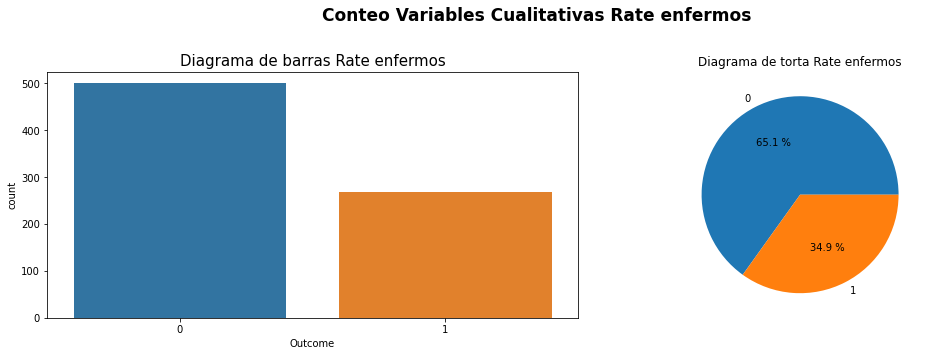

In [8]:
plot_bars(data['Outcome'], 'Rate enfermos')

In [9]:
print('Hay un desbalance en el conjunto de datos del 65% para los pacientes sanos y 35% para los pacientes enfermos.')

Hay un desbalance en el conjunto de datos del 65% para los pacientes sanos y 35% para los pacientes enfermos.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True)

# **Model**
---

In [12]:
def model_base():
  model = Sequential()
  model.add(Dense(12, input_dim=8, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(8, activation='relu', kernel_initializer='glorot_uniform'))
  model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

In [13]:
model = model_base()
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 300, batch_size=16, verbose=0)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [14]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

# **Curva de aprendizaje**
---

## **Curvas de aprendizaje de optimización**
---



In [15]:
def optimization_learning_curves(history, metrica, title: str= '', x_size:int=8, y_size:int=4, 
                                 font_size:int=15, x_label:str='Epoch',y_label:str='Loss')->None:
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(title, fontsize = font_size)
  ax.plot(history.history[metrica])
  ax.plot(history.history[f'val_{metrica}'])
  ax.set_xlabel(x_label, size = 12)
  ax.set_ylabel(y_label, size = 12)
  ax.legend(['Train', 'Test'], loc = 'upper left', fontsize = 12)
  ax.tick_params(labelsize = 12)
  fig.show()

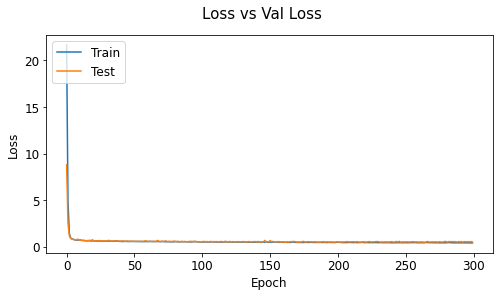

In [16]:
optimization_learning_curves(history, metrica='loss', title='Loss vs Val Loss')

- La perdida de entrenamiento y validación disminuyen hasta el punto de estabilida durante 300 epocas, con una `brecha de generailización` inperceptible.
- Los datos de entrenamiento y validación son representativos

# **Predictions**
---

In [19]:
y_pred = (model.predict(X_test)>0.5).astype('int32')
y_pred = np.reshape(y_pred, y_pred.shape[0])
y_pred

5/5 [==============================] - 0s 2ms/step


array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1],
      dtype=int32)

In [20]:
# Sesgo predictivo
#sesgo predicción = promedio de predicciones - promedio de etiquetas (observaciones) en el conjunto de datos
# Sick
def sesgo_prediction(prediction, validation)->tuple:
  average_prediction = (len(prediction[prediction==1])/len(prediction))
  average_label_target = (len(validation[validation==1]) / len(validation)) 
  sesgo_prediction = average_prediction - average_label_target
  return sesgo_prediction, average_prediction, average_label_target

In [21]:
sesgo, promedio_prediccion, promedio_validacion = sesgo_prediction(y_pred, y_test)
print(f'Promedio de predicciones:  {promedio_prediccion}')
print(f'Promedio de etiquetas: {promedio_validacion}')
print(f'Sesgo de predicción: {sesgo}')

Promedio de predicciones:  0.2532467532467532
Promedio de etiquetas: 0.35714285714285715
Sesgo de predicción: -0.10389610389610393


- Tiene un sesgo negativo del 10%, el modelo subestima, tiene un porcentaje de errores de no predicciones de pacientes con diabetes

In [22]:
def consufion_matrix(validation, prediction, title: str= 'Matriz de confusion', 
                     x_size:int=6, y_size:int=5, **kwards)->np.ndarray:
  matrix = metrics.confusion_matrix(validation, prediction)
  fig, ax = plt.subplots(nrows= 1, ncols=  1, figsize = (x_size,y_size))
  sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt = 'g', annot_kws={'size': 13})
  ax.set_title(title, size = 13)
  v = list(kwards.values())
  k = list(kwards.keys())

  if ax.get_xticklabels()[0].get_text() == v[0]:
    ax.xaxis.set_ticklabels([k[0], k[1]])
    ax.yaxis.set_ticklabels([k[0], k[1]])
  else:
    ax.xaxis.set_ticklabels([k[1], k[0]])
    ax.yaxis.set_ticklabels([k[1], k[0]])
  ax.tick_params(labelsize = 13)
  fig.show()
  return matrix

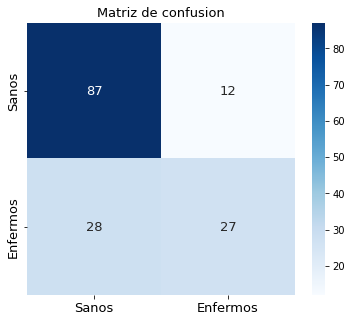

In [23]:
matrix = consufion_matrix(y_test, y_pred, **{'Enfermos':1, 'Sanos':0})

El modelo para la detección de enfermos es muy regular, ya que tiene un porcentaje conciderable de falsos negativos, ya que se está detectando sanos como enfermos. Como el conjunto de datos tiene desbalance, nos fijamos en la sensibilidad para detectar los enfermos, cuando realidad es enfemo

In [24]:
def metricas(validation, prediction, matrix, label:list=[1])->None:
  accuracy = '%.3f' % metrics.accuracy_score(validation, prediction)
  kappa = '%.3f' % metrics.cohen_kappa_score(validation, prediction)
  precision = '%.3f' % metrics.precision_score(validation, prediction, labels=label, average="macro")
  recall = '%.3f' % metrics.recall_score(validation, prediction, labels=label, average="macro")
  f1_score = '%.3f' % metrics.f1_score(validation, prediction, labels=label, average="macro")

  print(f'Accuracy  :   {accuracy}')
  print(f'Kappa     :   {kappa}')
  print(f'predicción enfermos')
  print(f'Precision:   {precision}')
  print(f'Recall    :   {recall}')

  VN, FP = 0, 0 
  if label == [1]:
    VN = matrix[0,0]
    FP = matrix[0,1]
  else:
    VN = matrix[0,0]
    FP = matrix[0,1]
  specificity = VN/(VN+FP)
  specificity = '%.3f' %  specificity

  print(f'Specificity:   {specificity}')
  print(f'F1-score   :   {f1_score}')
  return accuracy, kappa, precision, recall, f1_score, specificity

In [25]:
accuracy, kappa, precision, recall, f1_score, specificity = metricas(y_test, y_pred, matrix)

Accuracy  :   0.740
Kappa     :   0.395
predicción enfermos
Precision:   0.692
Recall    :   0.491
Specificity:   0.879
F1-score   :   0.574


In [26]:
print(f'El numero de predicciones correctas por el modelo es del {accuracy} , pero el inconveniente es que los datos se encuentran desbalanceados')
print(f'El kappa me indica que los estimadores de realidad y prediccion de la matrix de confusión tienen una corcondancia moderada del {kappa}')
print(f'El modelo tienen un sensibilidad moderada {recall} para la detección de casos de diabetes, cuando en realidad son de diabetis')

El numero de predicciones correctas por el modelo es del 0.740 , pero el inconveniente es que los datos se encuentran desbalanceados
El kappa me indica que los estimadores de realidad y prediccion de la matrix de confusión tienen una corcondancia moderada del 0.395
El modelo tienen un sensibilidad moderada 0.491 para la detección de casos de diabetes, cuando en realidad son de diabetis


# **PRECISION-RECALL**
---

In [28]:
y_prob = model.predict(X_test)
pos_prob = np.reshape(y_prob, y_prob.shape[0])

5/5 [==============================] - 0s 2ms/step


In [29]:
def precision_recall(y:np.ndarray, prediction_prob:np.ndarray, validation:np.ndarray)->float:
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  precision, recall, _ = metrics.precision_recall_curve(validation, prediction_prob)
  plt.plot(recall, precision, marker='.', label='Multi Layer Perceptron')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  auc_score = metrics.auc(recall, precision)
  plt.show()
  return auc_score

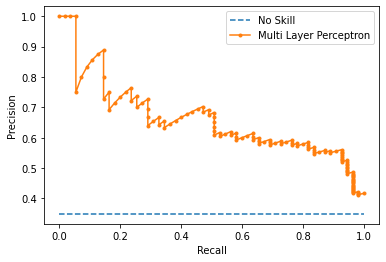

In [30]:
auc_score = precision_recall(y, pos_prob, y_test)

In [31]:
print('Multi Layer Perceptron PR AUC: %.3f' % auc_score)

Multi Layer Perceptron PR AUC: 0.660


El modelo tiene un habilidad por encima del promedio (Modelo sin habilidad) relativamente buena, pero no el mejor para el problema al cual se enfrenta, ya que implica la detección de una enfermedad apartir de algunas caracteristicas.

Como el proposito del proyecto, esta enfocado al autoaprendizaje no se aplicaron todas las tecnicas y conocimientos requeridos, sin embargo se realizaron variaciones en los hiperparametros, asi como manipular la estructura de la red y los valores en la partición de los datos.

**Tambien se aclara que el problema se pudo abordar mejor con otro timo de modelos de clasificación, sin embargo ese no hacia parte del objetivo, ya que se pretendia aprender sobre modelos de deep learning.**